# Imports

In [1]:
# Imports
import sys

import importlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import hist

top_dir = "/afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/"
sys.path.append(top_dir)

from analysis import plotting as p
from analysis import histograms as hgm
from analysis import outputs as out

from analysis import fitting as fit
from analysis import transfer_factor as tf

from IPython.display import Image, display

Welcome to JupyROOT 6.30/02


In [9]:
# Create a dictionary of the last 5 (short) commit hashes and the commit messages
import git
repo = git.Repo(top_dir)
commits = repo.iter_commits('master', max_count=5)
commit_info = {commit.hexsha[:7]: commit.message for commit in commits}

In [10]:
commit_info

{'36d2bed': 'Git integration',
 '3c3246f': 'Cleaned up some things, simplified analysis API\n',
 '53055b2': 'Before moving to hist\n'}

# WGamma Background Estimation
Leptonic W boson decay leads to events with leptons and real missing energy which can contaminate our signal region if the leptons are poorly reconstructed. The most obvious contribution comes from electrons which are missing a pixel seed and thus look like photons, however as we will see this is only part of the picture. It turns out that this background also contains contamination from jets that look like photons, particularly in the case where the prompt leptons are not reconstructed.

## Electron fakes photon

Electrons can fake photons if they are missing a pixel seed. To estimate this contribution to our signal region we construct an inverted pixel seed control region. The transfer factor is related to the probability of an electron being misidentified as a photon and is measured with a tag and probe method on the Z mass. This method assumes that the control region is dominated by real MET processes and real electrons.

### Transfer Factor

The observed number of events in the pixel seed control region can be represented by
$$n_{eg} = (1-f)n'_{eg}$$
where $n'_{eg}$ represents the number of events with a real electron and (possibly fake) photon. The factor $f$ represents the probability of an electron to not have a pixel seed (fake rate). This method relies on the assumption that the electron in the inverted pixel seed control region is real. The electron-fakes-photon prediction then can be written as 
$$
\begin{align*}
n_{gg} &= f n'_{eg} \\
&= \frac{f}{1-f}n_{eg} \\
&= \tau n_{eg}, \\
\end{align*}
$$
where $\tau =(f)/(1-f)$ is the transfer factor.

The transfer factor is estimated measured in data using tag-and-probe on the Z peak and validated in MC. The number of observed Z boson events in each channel can be represented as
$$n_{Z\to ee} = (1-f)^2 n_Z'$$
and
$$n_{Z\to eg} = 2f(1-f)n_Z'$$
where $nZ'$ is the total number of real Z bosons decaying to two electrons. The factor of two comes from the fact that in the eg channel either electron has a chance to be faked. Diving and rearranging the two equations we can solve for the transfer factor
$$\frac{1}{2} \frac{n_{Z\to eg}}{n_{Z\to ee}} = \frac{f}{(1 - f)}$$
or 
$$\tau = \frac{1}{2} \frac{n_{Z\to eg}}{n_{Z\to ee}}.$$

The transfer factor is a representation of the probability that an electron does not have an associated pixel seed. This probability is expected to vary with the electron's $\eta$ and the amount of pileup. To parameterize the transfer factor as a function of the pileup we can simply bin the invariant mass distributions in pileup and calculate the transfer factor in each bin. Binning the transfer factor in object level quantites like $\eta$ is more complicated.

Let's say we want to bin the transfer factor in $\eta$. To calculate the transfer factor in bin $i$ we can separate the candidate $Z \to ee$ events into four disjoint regions defined by whether or not each candidate is in bin $i$. One can calculate the transfer factor, assuming that both objects are in the same bin, however you would then lose out on the available information from the other regions. While we assume (for now) that the transfer factor is not dependent on the $p_T$ ordering of the pair of electrons we will distinguish between these for clarity of notation. We can write the observed number of $Z\to ee$ events in each (relevant) region as:
$$
\begin{align*}
n_{Z\to eAeA} &= (1-f^A)^2 n_{Z\to eAeA}' \\
n_{Z\to eAeB} + n_{Z\to eBeA} &= (1-f^A)(1-f^B)(n_{Z\to eAeB}' + n_{Z\to eBeA}') \\
\end{align*}
$$
where the subscript $eAeB$ denotes that the leading electron is in region $A$ which is in bin $i$, and the subleading electron is in some disjoint region $B$.

Similarly we can write the number of observed $Z \to eg$ events as:
$$
\begin{align*}
n_{Z\to gAeA} + n_{Z\to eAgA} &= 2f^A(1-f^A)n_{Z\to eAeA}' \\
n_{Z\to gAeB} + n_{Z\to eBgA} &= f^A(1-f^B)(n_{Z\to eAeB}' + n_{Z\to eBeA}') \\
\end{align*}
$$
where only the regions with $g\in A$ are relevant.

With this we can write the transfer factor in region A as:
$$
\begin{align*}
\tau_A &= \frac{(n_{Z\to gAeA}+n_{Z\to eAgA})+(n_{Z\to gAeB}+n_{Z\to eBgA})}{2n_{Z\to eAeA}+(n_{Z\to eAeB}+n_{Z\to eBeA})} \\
&= \frac{f^A}{(1-f^A)} \frac{ 2(1-f^A)n_{Z\to eAeA}'+(1-f^B)(n_{Z\to eAeB}' + n_{Z\to eBeA}')}{2(1-f^A) n_{Z\to eAeA}'+ (1-f^B)(n_{Z\to eAeB}' + n_{Z\to eBeA}')} \\
&= \frac{f^A}{(1-f^A)}.
\end{align*}
$$

### Fitting
The number of Z bosons are found by fitting a signal plus background model on the invariant mass distributions of the two leading objects. The signal shape is represented as a Voigt profile and the background is assumed to be linear.

### Validation

To validate this background estimation method we start with the simple case and apply a transfer factor parameterized by only the year. Because the transfer factor is not a function of any object quantites it is simply $n_{Z\to eg}/2n_{Z\to ee}$. The transfer factor is measured in the DY MC and applied to the WGJets and TTGJets MC.

In [137]:
importlib.reload(out)
DYJetsToLL_DY_2016 = out.load_outputs("DYJetsToLL", "2017", "DY")
DYJetsToLL_DY_2016.events.df

,lead_pt,subl_pt,lead_eta,subl_eta,lead_hasPixelSeed,subl_hasPixelSeed,invariant_mass,min_mt,nvtx,met,bdt,weight,lead_genMatch,subl_genMatch,n_gen_electrons,n_gen_electrons_matched_electron,n_gen_electrons_matched_photon
0,108.040146,80.270088,-0.405222,-0.508793,True,True,88.166856,None,32,37.250592,0.143389,0.513486,genEle,genEle,2,2,0
1,94.668228,84.571373,0.353032,0.353863,True,True,87.983337,None,29,31.250252,-0.145897,0.848801,genEle,genEle,2,2,0
2,103.902733,88.270882,-0.467045,-0.147990,False,True,95.143040,None,22,33.607280,-0.031143,0.732425,genEle,genEle,2,1,1
3,106.303406,99.777748,0.812203,1.149015,True,True,92.989672,None,42,37.507086,0.152692,0.137855,genEle,genEle,2,2,0
4,105.830269,94.070976,0.908528,0.073530,True,True,92.608319,None,31,47.271934,-0.037272,0.859487,genEle,genEle,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32612,198.452866,137.408493,-1.636496,-1.360610,True,True,89.127426,None,30,51.351029,0.065522,0.032414,genEle,genEle,2,2,0
32613,327.194763,91.892586,1.190838,0.809367,True,True,82.446560,None,12,84.863841,-0.230988,0.024173,genEle,genEle,2,2,0
32614,149.570709,88.951439,-0.281559,0.486151,True,True,93.332257,None,32,52.476378,0.025059,0.025786,genEle,genEle,2,2,0
32615,282.856689,131.068802,1.878897,2.325421,True,True,90.993891,None,9,95.783754,0.008289,0.021683,genJet,genEle,2,2,0


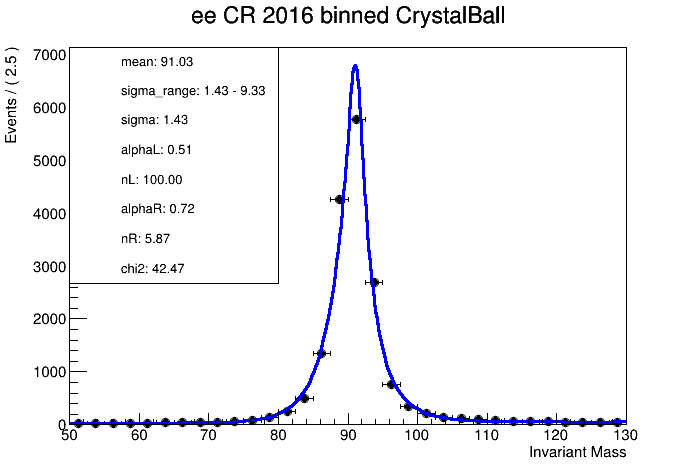

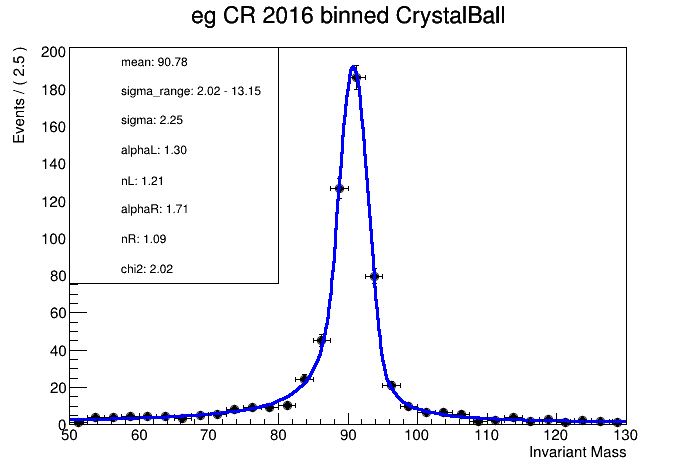

[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(linear_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(linear_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb,linear)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) Calculating covariance matrix according to the asymptotically correct approach. If you find this method useful please consider citing https://arxiv.org/abs/1911.01303.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(linear_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactiva

Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/outputs/plots/egtf/fits/ee CR 2016_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/outputs/plots/egtf/fits/eg CR 2016_binned_CrystalBall.png has been created


In [3]:
# importlib.reload(fit)
DY_events = DYJetsToLL_DY_2016.events.df

ee_CR = DY_events['lead_hasPixelSeed'] & DY_events['subl_hasPixelSeed']
eg_CR = DY_events['lead_hasPixelSeed'] != DY_events['subl_hasPixelSeed']

# importlib.reload(fit)
ee_fit = fit.fit(DY_events[ee_CR], 'ee CR 2016', 'binned')
eg_fit = fit.fit(DY_events[eg_CR], 'eg CR 2016', 'binned')

display(Image(ee_fit['filename']))
display(Image(eg_fit['filename']))

tf = eg_fit['nsig']/(2*ee_fit['nsig'])

In [150]:
importlib.reload(tf)
tf.compare_tfs(tf.NaiveTF(True), tf.CombinedTF(True))

2016:
NaiveTF: tf : {'BB': 0.01912730922942595, 'EE': 0.025686041643815962}, tf err: {'BB': 0.0013877003678714331, 'EE': 0.0008464071238098189}
CombinedTF: tf : {'barrel': 0.017565607870123588, 'endcap': 0.023930033723256014}, tf err: {'barrel': 5.4332311068186916e-05, 'endcap': 0.0009478071919135387}
2017:
NaiveTF: tf : {'BB': 0.022203405162015962, 'EE': 0.004006711578630624}, tf err: {'BB': 6.371284997466418e-05, 'EE': 0.0001652949806345658}
CombinedTF: tf : {'barrel': 0.019979607937982445, 'endcap': 0.0041332234826495316}, tf err: {'barrel': 0.000490605001148035, 'endcap': 0.020472234966559477}


In [154]:
importlib.reload(tf)
tf.compare_tfs(tf.NaiveTF(True), tf.CombinedTF(True))

2016:
NaiveTF: tf : {'BB': 0.01913, 'EE': 0.025686}, tf err: {'BB': 0.00139, 'EE': 0.000846}
CombinedTF: tf : {'barrel': 0.018, 'endcap': 0.02393}, tf err: {'barrel': 0.0, 'endcap': 0.000948}
2017:
NaiveTF: tf : {'BB': 0.022, 'EE': 0.004007}, tf err: {'BB': 0.0, 'EE': 0.000165}
CombinedTF: tf : {'barrel': 0.01998, 'endcap': 0.0041}, tf err: {'barrel': 0.000491, 'endcap': 0.0205}


In [161]:
importlib.reload(p)
importlib.reload(hgm)
importlib.reload(fit)

def egtf_mc_validation(dType_or_dTypes, transferFactor=tf.SimpleTF(True)):

    if isinstance(dType_or_dTypes, str):
        dTypes = [dType_or_dTypes]
    elif isinstance(dType_or_dTypes, list):
        dTypes = dType_or_dTypes
    else:
        raise ValueError("dType_or_dTypes must be a string or list of strings")

    assert all([dType in ["WGJets", "TTGJets"] for dType in dTypes]), "dType must be DYJetsToLL or GJets"

    h_gg_SR = hgm.SimpleHistogram()
    h_gg_genEle = hgm.SimpleHistogram()
    h_scaled_eg = hgm.SimpleHistogram()

    for year in ['2016', '2017', '2018']:
        for dType in dTypes:
            df_year = out.load_outputs(dType, year, "EG").events.df

            gg_SR = ~df_year['lead_hasPixelSeed'] & ~df_year['subl_hasPixelSeed']
            has_gen_electron = (df_year['lead_genMatch'] == "genEle") | (df_year['subl_genMatch'] == "genEle")
            eg_CR = df_year['lead_hasPixelSeed'] != df_year['subl_hasPixelSeed']

            h_gg_SR += hgm.SimpleHistogram().from_hist(hgm.analysis_hist(df_year[gg_SR]))
            h_gg_genEle += hgm.SimpleHistogram().from_hist(hgm.analysis_hist(df_year[gg_SR & has_gen_electron]))

            tf = transferFactor.tf[year]
            tf_err = transferFactor.tf_err[year]
            h_scaled_eg += hgm.SimpleHistogram().from_hist(hgm.analysis_hist(df_year[eg_CR])).scale(tf, tf_err)

    # Plotting
    fig, axs = plt.subplots(2,3, figsize=(15,10), sharey=True, gridspec_kw={'height_ratios': [2, 1]})

    p.plot_analysis_bins(h_gg_SR, "gg", fig=fig, axs=axs[0,:])
    p.plot_analysis_bins(h_gg_genEle, "gg genEle", fig=fig, axs=axs[0,:])
    p.plot_analysis_bins(h_scaled_eg, "scaled eg", fig=fig, axs=axs[0,:])

    h_ratio = h_gg_SR/h_scaled_eg
    p.plot_analysis_bins(h_ratio, None, ylabel="gg/scaled eg", fig=fig, axs=axs[1,:], print_bdt_labels=False)

    fig.subplots_adjust(hspace=0)

    for i in range(3):
        axs[0,i].set_xticklabels([])
    axs[0,0].set_yticks(axs[0,0].get_yticks()[1:])
    axs[1,0].set_yticks(axs[1,0].get_yticks()[:-1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


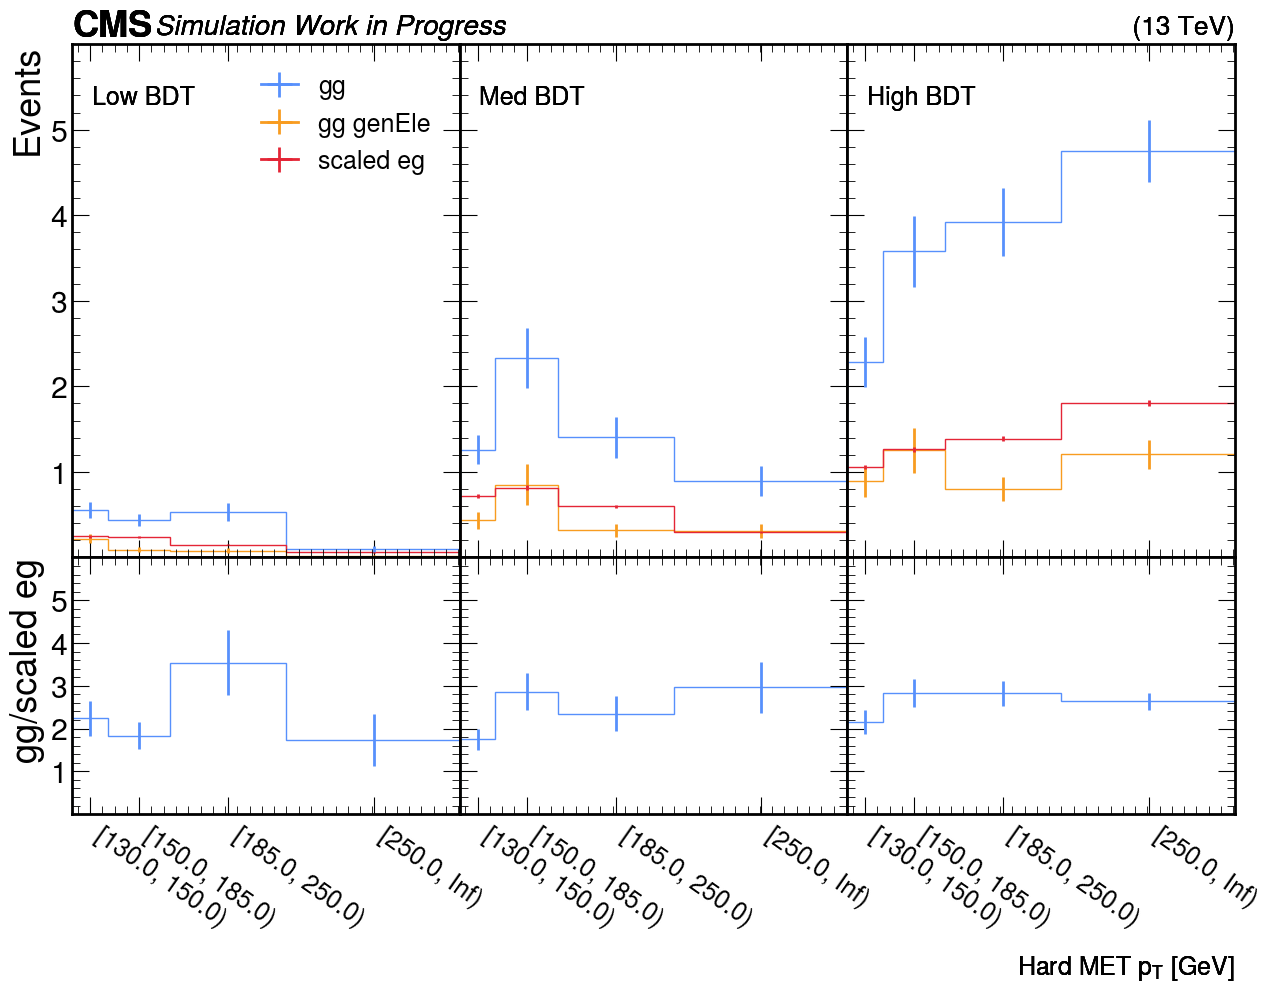

In [163]:
egtf_mc_validation("WGJets")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


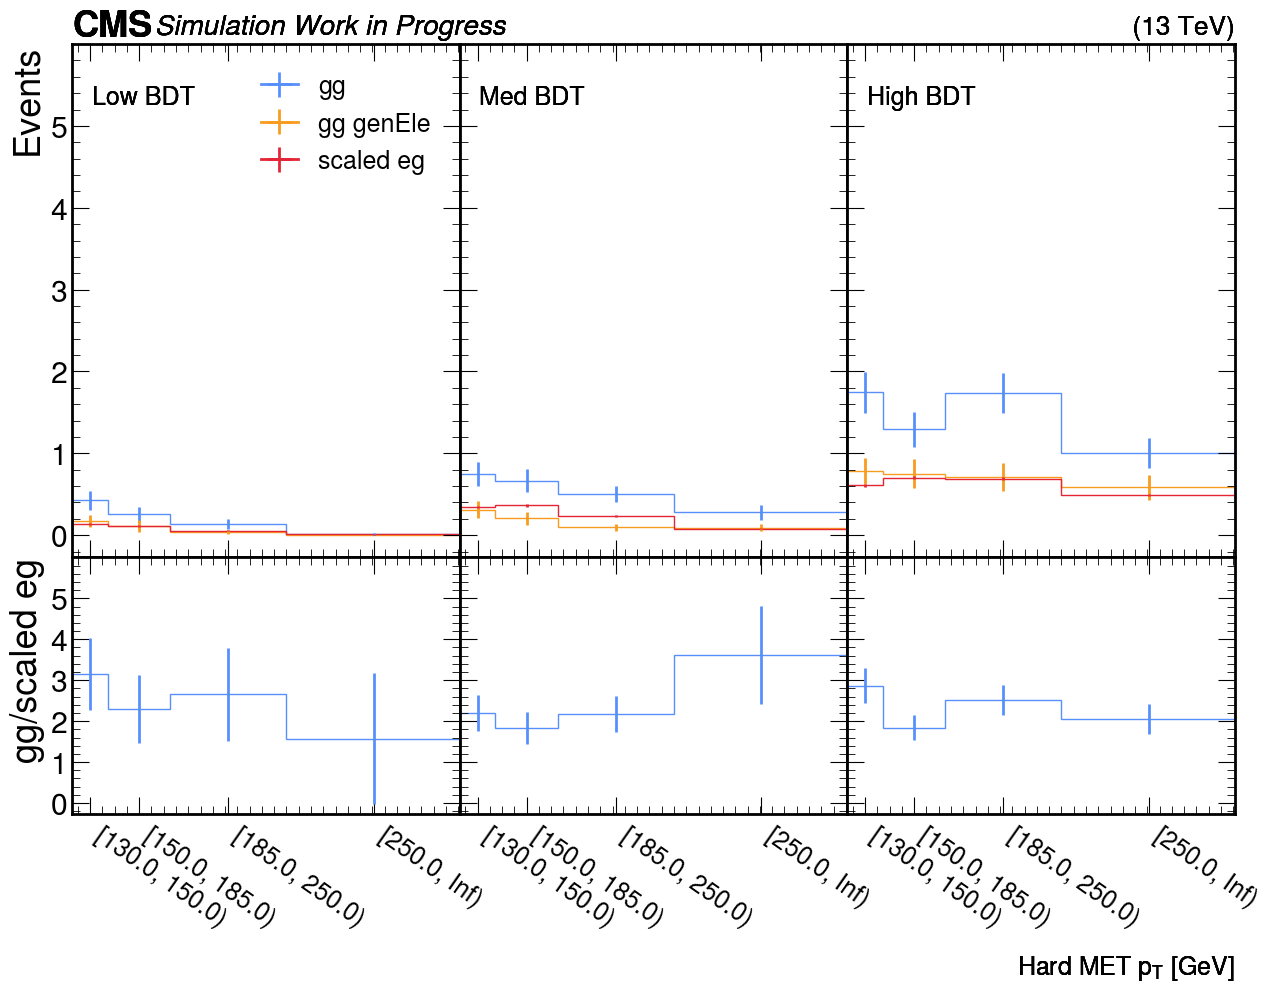

In [164]:
egtf_mc_validation("TTGJets")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


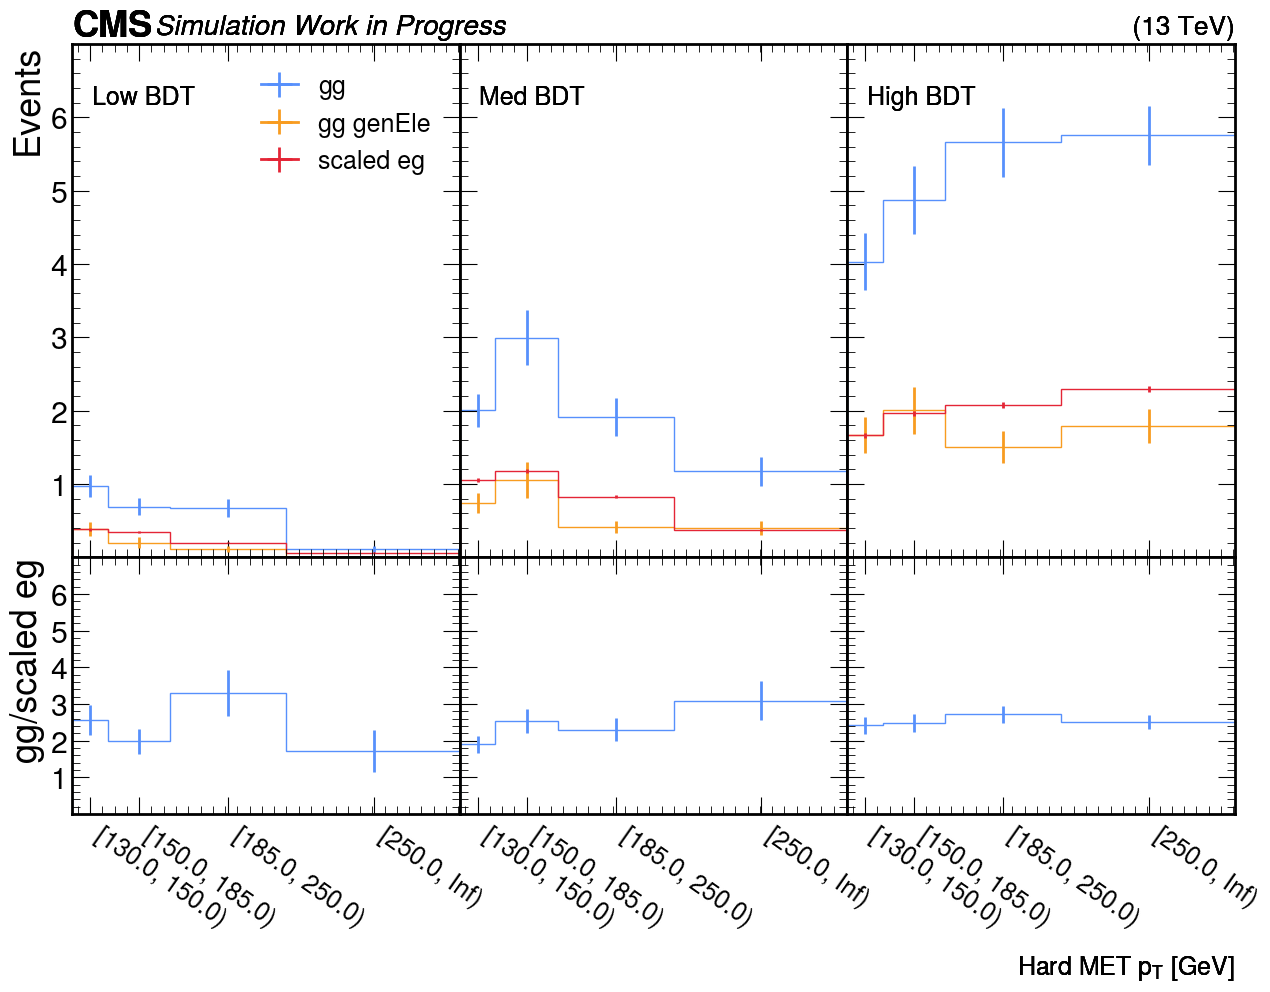

In [162]:
egtf_mc_validation(["WGJets", "TTGJets"])

In [5]:
importlib.reload(p)
def background_matrix(dType):
    assert(dType != 'data')
    df = out.load_outputs(dType, "Run2", "EG").events.df
    
    gg_SR = ~df['lead_hasPixelSeed'] & ~df['subl_hasPixelSeed']
    p.plot2d(hgm.genBackground(df[gg_SR]), display_bin_values=True, cbar=False, fig_size=(9,9))

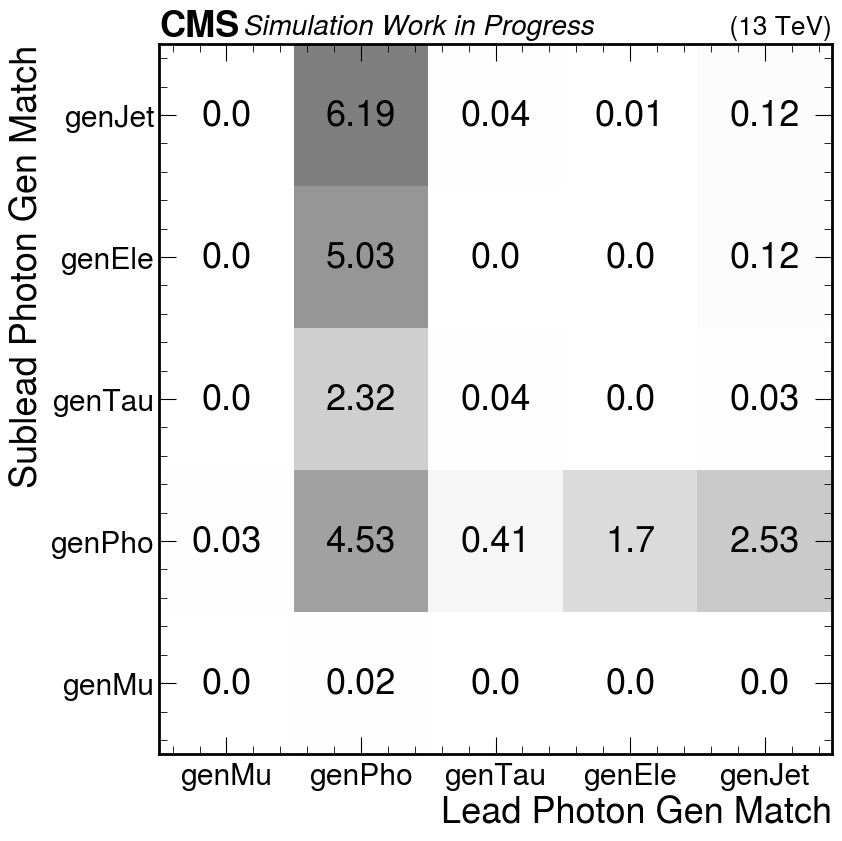

In [6]:
background_matrix("WGJets")

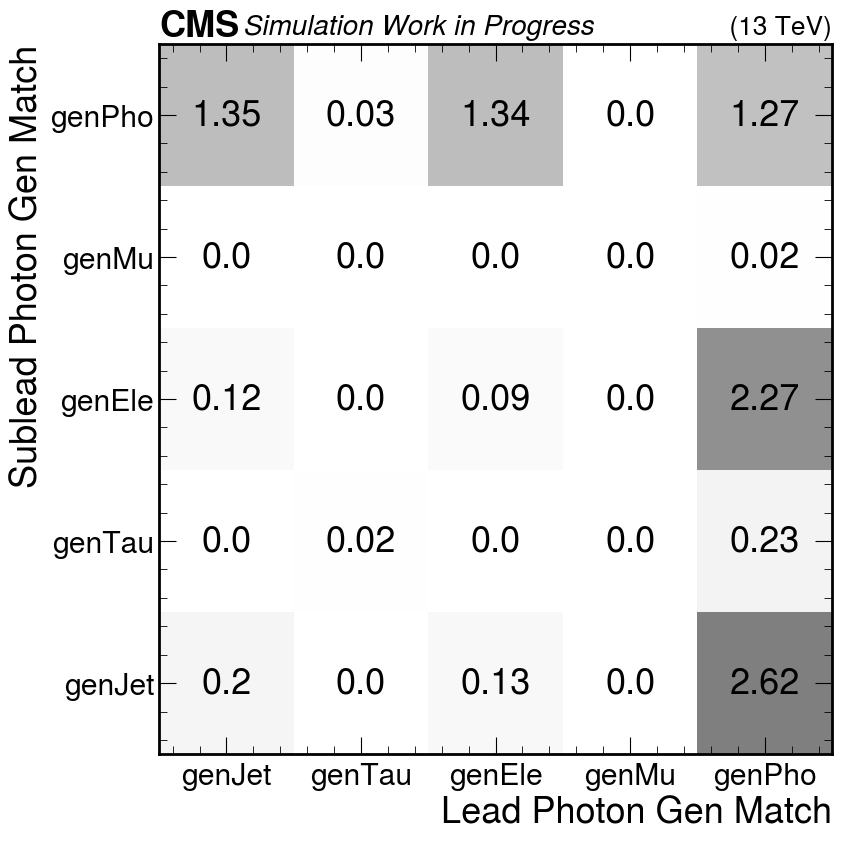

In [4]:
background_matrix("TTGJets")

### Transfer Factor Dependence

The electron-fakes-photon rate is expected to be dependent on several quantities including the pileup and the $\eta$ of the electron. Additionally we can study the dependence on a number of other quantites like $p_T$ and HT. The limiting factor in studying these dependencies is the statistics of the Z boson sample. The number of dimensions and bins in each dimension must be chosen carefully to ensure that there are enough events in each bin to make a meaningful measurement. 

In [25]:
import mplhep as hep
plt.style.use(hep.style.CMS)

importlib.reload(fit)

obj_vars = ['Pt', 'Eta', 'Phi']

def plot_transfer_factor_dependence(dType, year, bins, var_name):
    assert dType in ['DYJetsToLL', 'data']

    isData = dType == 'data'

    obj_var = var_name in obj_vars

    if dType == "DYJetsToLL" and year == "2018":
        year = "2017"

    df = out.load_outputs(dType, year, "DY").events.df

    if obj_var:
        df[f'lead_{var_name}_bin'] = np.digitize(df[f'lead_{var_name}'], bins)
        df[f'subl_{var_name}_bin'] = np.digitize(df[f'subl_{var_name}'], bins)
    else:
        df[f'{var_name}_bin'] = np.digitize(df[f'{var_name}'], bins)

    ee_CR = df['lead_hasPixelSeed'] & df['subl_hasPixelSeed']
    eg_CR = df['lead_hasPixelSeed'] != df['subl_hasPixelSeed']

    tf_values = [0]*(len(bins)-1)
    tf_errors = [0]*(len(bins)-1)

    for i in range(len(bins)-1):
        bin_tag = f"{bins[i]}_{bins[i+1]}"
        bin_mask = None
        if var_name in obj_vars:
            bin_mask = (df[f'lead_{var_name}_bin'] == i+1) & (df[f'subl_{var_name}_bin'] == i+1)
        else:
            bin_mask = df[f'{var_name}_bin'] == i+1
        
        if sum(bin_mask) == 0:
            continue

        ee_fit_info = fit.fit(df[ee_CR & bin_mask], f'{dType} ee CR {year} {bin_tag}', 'binned')
        eg_fit_info = fit.fit(df[eg_CR & bin_mask], f'{dType} eg CR {year} {bin_tag}', 'binned')

        ee = ee_fit_info['nsig']
        eg = eg_fit_info['nsig']
        tf_values[i] = eg/(2*ee)

        ee_err = eg_fit_info['nsig_err']
        eg_err = ee_fit_info['nsig_err']
        tf_errors[i] = np.sqrt((1/(2*ee))**2 * eg_err**2 + (eg/(2*ee**2))**2 * ee_err**2)

    fig, ax = plt.subplots(figsize=(9,9))
    hep.histplot((tf_values, bins), yerr=tf_errors, ax=ax, label=dType, color='black')
    ax.set_xlabel(var_name)
    ax.set_ylabel("Transfer Factor")
    hep.cms.label(
        ax=ax,
        data=isData,
        year=year,
        label="WIP" if isData else f"{dType} WIP"
    )

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable x expanded to nearest bin boundaries: [50.2491,129.388] --> [50,130]
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(linear_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(linear_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb,linear)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) Calculating covariance matrix according to the asymptotically correct approach. If you find this method useful please consider citing https://arxiv.org/abs/1911.01303.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(li

Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL ee CR 2017 0_0.3_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL eg CR 2017 0_0.3_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL ee CR 2017 0.3_0.8_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL eg CR 2017 0.3_0.8_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL ee CR 2017 0.8_1.4442_binned_CrystalBall.png has been created
Info in <TCanvas::Print>: png file /afs/crc.nd.edu/user/a/atownse2/Public/SUSYDiPhoton/plots/egtf/fits/DYJetsToLL eg CR 2017 0.8_1.4442_

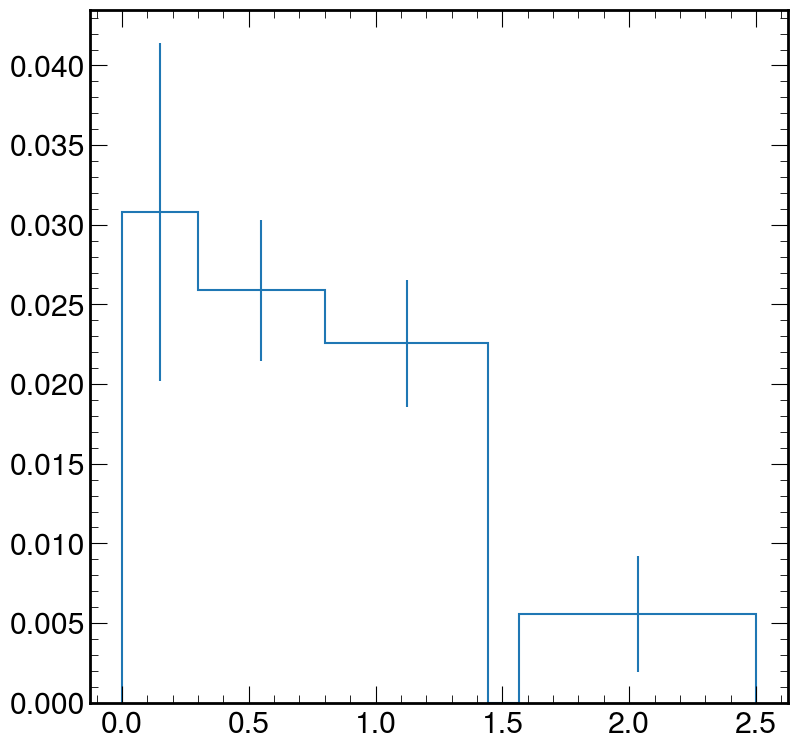

In [26]:
eta_bins = [0, 0.3, 0.8, 1.4442, 1.566, 2.5]
plot_transfer_factor_dependence("DYJetsToLL", "2017", eta_bins, "Eta")